###Run this command only if you have saved files in your drive in a folder called 'MNIST_GAN'

In [0]:
!cp /content/drive/'My Drive'/MNIST_GAN/adversarial.h5 ./
!cp /content/drive/'My Drive'/MNIST_GAN/generator.h5 ./
!cp /content/drive/'My Drive'/MNIST_GAN/discriminator.h5 ./

###making directory to store GAN output

In [0]:
!mkdir mnist_gan_output

In [0]:
from keras import  Sequential
from keras.layers import Dense,Conv2D,Conv2DTranspose,Flatten,LeakyReLU,Reshape
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from keras.models import load_model

### loading images from tensorflow and keras

In [0]:
#loading from tensorflow
tf_inp_images = input_data.read_data_sets("mnist",one_hot=True).train.images
tf_inp_images = tf_inp_images.reshape(-1, 28,28, 1).astype(np.float32)
    
#loading from keras
(keras_inp_images,dontcare),(dontcare,dontcare) = mnist.load_data()
keras_inp_images = keras_inp_images.reshape(-1,28,28,1).astype(np.float32)

In [0]:
img_temp = keras_inp_images[0,:,:,:]
plt.imshow( img_temp.reshape( (28,28) ) , cmap='gray' )
print(img_temp)
#needs normalization as values range from 0 to 255

In [0]:
img_temp = tf_inp_images[0,:,:,:]
plt.imshow( img_temp.reshape( (28,28) ) , cmap='gray' )
print(img_temp)
#does not need normalization as values already between 0 to 1

In [0]:
class GAN:

  def __init__(self,latent_variables=20):
    self.gen = None
    self.discrim = None
    self.DModel = None
    self.GModel = None
    self.latent_variables=latent_variables

    #loading from keras without normalization
    # (self.inp_images,dontcare),(dontcare,dontcare) = mnist.load_data()
    # self.inp_images = self.inp_images.reshape(-1,28,28,1).astype(np.float32)


    #loading from tensorflow
    #self.inp_images = input_data.read_data_sets("mnist",one_hot=True).train.images
    #self.inp_images = self.inp_images.reshape(-1, 28,28, 1).astype(np.float32)
    
    #loading from keras with normalization
    (self.inp_images,dontcare),(dontcare,dontcare) = mnist.load_data()
    self.inp_images = self.inp_images.reshape(-1,28,28,1).astype(np.float32)/255


    self.discriminator_mnist= self.discriminator_model()
    self.adversarial_mnist= self.adver_model()
    self.generator_mnist = self.generator()
      
  def train(self,batch_size=256,steps=5000,discrim_steps=1,summary_steps=100,continue_training=False):

    if continue_training:
      print("loading old models")
      generator_mnist = load_model('generator.h5',compile=False)
      discriminator_mnist = load_model('discriminator.h5')
      adversarial_mnist = load_model('adversarial.h5')

    for i in range(steps):
      for j in range(discrim_steps):
        #discrimModel train {k times,k=1}
        noise = np.random.uniform(-1.0,1.0,size=[batch_size,self.latent_variables])
        images_gen = self.generator_mnist.predict(noise)
        images_real = self.inp_images[ np.random.randint( 0,self.inp_images.shape[0],size=batch_size),:,:,: ]
        x= np.concatenate((images_real,images_gen))
        y= np.ones([2*batch_size,1])
        y[batch_size:,:]=0
        (d_loss,d_acc) = self.discriminator_mnist.train_on_batch(x,y)
      
      #advModel train
      noise = np.random.uniform(-1.0,1.0,size=[batch_size,self.latent_variables])
      y= np.ones([batch_size,1])
      (a_loss,a_acc) = self.adversarial_mnist.train_on_batch(noise,y)

      if i%summary_steps==0:
        print("training step: ",str(i),"(d_loss,d_acc): ",str(d_loss), str(d_acc),"(a_loss,a_acc): ",str(a_loss), str(a_acc) )
        noise_temp = np.random.uniform(-1.0,1.0,size=[1,self.latent_variables])
        img_temp = self.generator_mnist.predict(noise_temp)
        plt.imshow( img_temp.reshape( (28,28) ) , cmap='gray' )
        plt.savefig('mnist_gan_output/img_'+str(i)+'.png')
        plt.close('all')
    self.generator_mnist.save('generator.h5')
    self.discriminator_mnist.save('discriminator.h5')
    self.adversarial_mnist.save('adversarial.h5')

  def discriminator(self):
    if self.discrim:
     print("reusing old discrim") 
     return self.discrim
    
    self.discrim = Sequential()

    self.discrim.add( Conv2D(64,5,strides=2,padding='same', input_shape=(28,28,1)) )
    self.discrim.add(LeakyReLU(0.2))

    self.discrim.add( Conv2D(128,5,strides=2,padding='same') )
    self.discrim.add(LeakyReLU(0.2))

    self.discrim.add( Conv2D(256,5,strides=2,padding='same') )
    self.discrim.add(LeakyReLU(0.2))

    self.discrim.add( Flatten() )

    self.discrim.add( Dense(1,activation='sigmoid') )
    self.discrim.summary()
    return self.discrim

  def generator(self):
    if self.gen:
     print("reusing old gen")
     return self.gen

    self.gen = Sequential()
    self.gen.add( Dense(7*7*128 , input_dim=self.latent_variables, activation='relu' ) )
    self.gen.add( Reshape( (7,7,128) ) )
    #7 7 256

    self.gen.add( Conv2DTranspose(64,5,strides=2, padding='same') )
    self.gen.add( LeakyReLU(0.2) )
    #14 14 64
    self.gen.add( Conv2DTranspose(32,5,strides=2, padding='same') )
    self.gen.add( LeakyReLU(0.2) )
    #28 28 1
    self.gen.add( Conv2DTranspose(1,5,strides=1, padding='same', activation='sigmoid') )

    self.gen.summary()
    return self.gen
  
  def discriminator_model(self):
    if self.DModel:
     print("reusing old discrim_model")
     return self.DModel
    optim = RMSprop(lr=0.0002, decay=6e-8)
    self.DModel = Sequential()
    self.DModel.add (self.discriminator())
    self.DModel.compile(loss='binary_crossentropy',optimizer = optim,metrics =['accuracy'])
    return self.DModel

  def adver_model(self):
    if self.GModel:
     print("reusing old adver_model")
     return self.GModel

    optim = RMSprop(lr=0.0001, decay=3e-8)
    self.GModel = Sequential()
    self.GModel.add (self.generator())
    self.GModel.add (self.discriminator())
    self.GModel.compile(loss='binary_crossentropy',optimizer = optim,metrics =['accuracy'])
    return self.GModel


In [0]:
gan = GAN()
gan.train(batch_size=256,steps=5000,discrim_steps=1,summary_steps=100,continue_training=True)

###Copying .h5 files to gdrive to continue training or for running generator later on

In [0]:
!cp adversarial.h5 /content/drive/'My Drive'/MNIST_GAN
!cp discriminator.h5 /content/drive/'My Drive'/MNIST_GAN
!cp generator.h5 /content/drive/'My Drive'/MNIST_GAN

###Using the generator model to create MNIST numbers

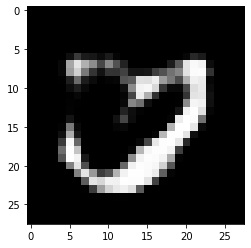

In [0]:
my_gen = load_model('generator.h5',compile=False)
noise=np.array([0.7,-0.75,-0.7,-0.6,0.7,0.8,0.3,0.5,0.1,0.0,0.2,0.4,0.4,-0.7,-0.6,0.7,-0.75,-0.7,-0.6,0.7])
noise = noise.reshape(-1,20)
img_temp = my_gen.predict(noise)

plt.imshow( img_temp.reshape( (28,28) ) , cmap='gray' )


In [0]:
|

12
